In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

# Loading data & Pre-processing

Loading Salinas images and their ground truth

In [2]:
data1 = sio.loadmat('Salinas_corrected.mat')#load .mat file
data2 = sio.loadmat('Salinas_gt.mat')#load .mat file
print(data1.keys())
print(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
salinas_img = data1['salinas_corrected']#choose 'salinas_corrected' value in Salinas_corrected.mat dictionary
salinas_labels = data2['salinas_gt']#choose 'salinas_gt' value in Salinas_gt.mat dictionary

In [4]:
print("Salinas shape: {}".format(salinas_img.shape))

Salinas shape: (512, 217, 204)


Text(0.5, 1.0, 'Salinas labels')

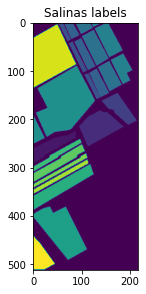

In [5]:
# Display ground truth for each image
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(salinas_labels, cmap='viridis')
plt.title('Salinas labels')

# Plot the curve of one sample

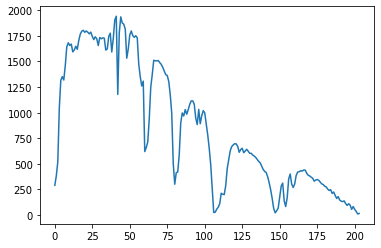

In [6]:
# get any position 
pos = [0,1]
feature = salinas_img[pos[0],pos[1],:]
plt.plot(feature)

# Data count of each class

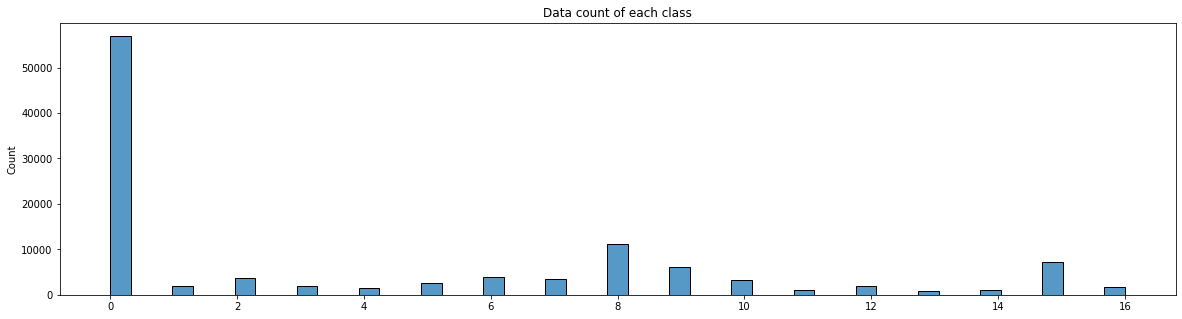

In [7]:
plt.figure(figsize=(20,5))
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.title("Data count of each class")
plt.show()

In [8]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
y_gt = salinas_labels.ravel()
print("Salinas shape: {}".format(X_salinas.shape))

Salinas shape: (111104, 204)


# Remove the background

In [9]:
#delete the zero label(background)
X_salinas_reduced = np.delete(X_salinas, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

In [10]:
#Data after removing the background
print(X_salinas_reduced.shape)
print(y.shape)

(54129, 204)
(54129,)


In [11]:
#get the number of class（label）
n_classes_salinas = len(np.unique(salinas_labels)) - 1

In [12]:
print("Number of labels Salinas: {}".format(n_classes_salinas))
print(np.unique(y))

Number of labels Salinas: 16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## PCA

In [13]:
#this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
#choose the main feartures using PCA
print("Fitting the PCA")
pca_model = PCA()
pca_model.fit(X_salinas_reduced)
var_cumsum = pca_model.explained_variance_ratio_.cumsum()
n_components_salinas = len(var_cumsum[var_cumsum <= 0.997])
print("Number of components Salinas:")
print(n_components_salinas) 

Fitting the PCA
Number of components Salinas:
3


Feature extraction

In [14]:
pca_model = PCA(n_components = n_components_salinas)
pca_model.fit(X_salinas_reduced)
X_salinas_reduced_pca = pca_model.transform(X_salinas_reduced)
print(X_salinas_reduced_pca.shape)

(54129, 3)


# Rescale the data into range (0,1)

In [15]:
# setup the MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalization: transform the dataset into the range [0,1]
X_salinas_01 = scaler.fit_transform(X_salinas_reduced_pca)

In [16]:
print(X_salinas_01)

[[0.51413904 0.79668544 0.11909781]
 [0.5035598  0.77875162 0.13072434]
 [0.49914049 0.77406888 0.13800365]
 ...
 [0.5757803  0.30620281 0.47124257]
 [0.56261292 0.30313621 0.46584862]
 [0.53912952 0.2971203  0.46222048]]


The first graph shows the variance ratio of features(PCA) and the second graph is the cumulative sum of variance ratio

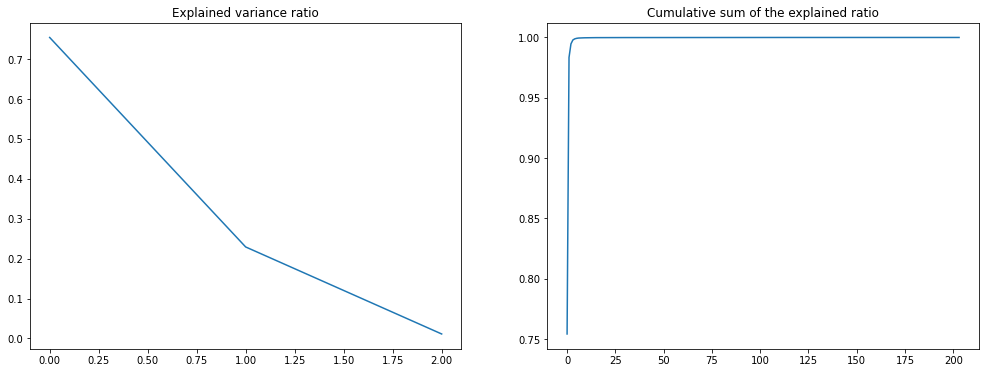

In [17]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_[:10])
plt.title("Explained variance ratio")

plt.subplot(1, 2, 2)
plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

## Split data into train / test

Using 75% of the data as the training dataset and 25% for the testing.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_salinas_01, y, test_size=0.25, random_state=42)

In [19]:
print("Train shape: {}".format(X_train.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test shape: {}".format(X_test.shape))
print("Test labels shape: {}".format(y_test.shape))

Train shape: (40596, 3)
Train labels shape: (40596,)
Test shape: (13533, 3)
Test labels shape: (13533,)


In [20]:
#Model instantiation
salinas_model_naive_bayes = GaussianNB()

Using K-fold method to realize Cross-validation

In [21]:
%%time
scores = cross_val_score(salinas_model_naive_bayes, X_train, y_train, cv=5,scoring = 'accuracy')

Wall time: 84.8 ms


In [22]:
print(scores)
print("The average score is {}".format(np.mean(scores)))

[0.83559113 0.84640966 0.83446237 0.84185244 0.83630989]
The average score is 0.8389250993685675


In [23]:
%%time
salinas_model_naive_bayes.fit(X_train, y_train)#fitting the model

Wall time: 14.9 ms


GaussianNB()

Output the training score and testing score

In [24]:
%%time
salinas_model_naive_bayes.verbose=0
preds_salinas_test = salinas_model_naive_bayes.predict(X_test)
salinas_test_score = accuracy_score(y_test, preds_salinas_test)
print("Salinas training score {} and testing {}".format(np.mean(scores), salinas_test_score))

Salinas training score 0.8389250993685675 and testing 0.8387645015887091
Wall time: 14 ms


The comparison histogram of predicted labels and expected labels

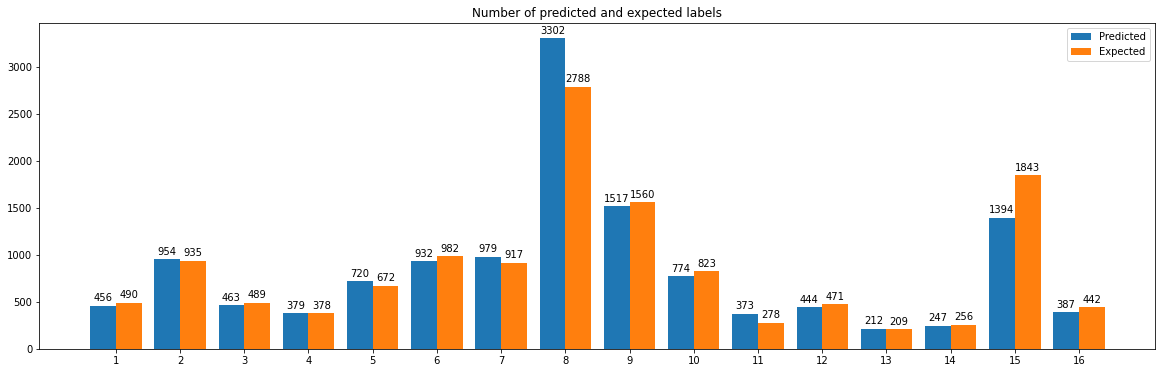

In [25]:
#this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
fig, axs = plt.subplots(figsize=(20, 6))

bar_x, bar_count_pred = np.unique(preds_salinas_test, return_counts=True)
bar1 = axs.bar(bar_x - 1.2, bar_count_pred, 0.4, label="Predicted")

bar_x, bar_count_exp = np.unique(y_test, return_counts=True)
bar2 = axs.bar(bar_x - 0.8, bar_count_exp, 0.4, label="Expected")

title='Number of predicted and expected labels'

axs.bar_label(bar1, padding=3)
axs.bar_label(bar2, padding=3)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title(title)
axs.legend()
plt.show()

Predict the total data

In [26]:
%%time
total_preds_salinas = salinas_model_naive_bayes.predict(X_salinas_01)

Wall time: 52.8 ms


Final performance of this model

In [27]:
#accuracy
total_preds_salinas_score = accuracy_score(y, total_preds_salinas)
print("The final accuracy of this model is {}".format(total_preds_salinas_score))

The final accuracy of this model is 0.8387001422527666


In [28]:
#mean square error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y, total_preds_salinas))

6.55905337249903


In [29]:
#precision,recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(y, total_preds_salinas))

              precision    recall  f1-score   support

           1       0.99      0.94      0.97      2009
           2       0.97      0.98      0.97      3726
           3       0.80      0.78      0.79      1976
           4       0.98      0.99      0.99      1394
           5       0.89      0.96      0.92      2678
           6       1.00      0.95      0.98      3959
           7       0.92      0.97      0.94      3579
           8       0.69      0.80      0.74     11271
           9       0.99      0.96      0.97      6203
          10       0.79      0.71      0.75      3278
          11       0.67      0.91      0.77      1068
          12       0.96      0.89      0.93      1927
          13       0.97      0.97      0.97       916
          14       0.95      0.93      0.94      1070
          15       0.67      0.52      0.58      7268
          16       0.85      0.78      0.81      1807

    accuracy                           0.84     54129
   macro avg       0.88   

# Result visualization

In [30]:
#Establish the index of 16 labels 
idx = np.argwhere(salinas_labels.flatten() != 0).flatten()

In [31]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
#Passing prediction data into an image
salinas_preds_img[idx] = total_preds_salinas
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

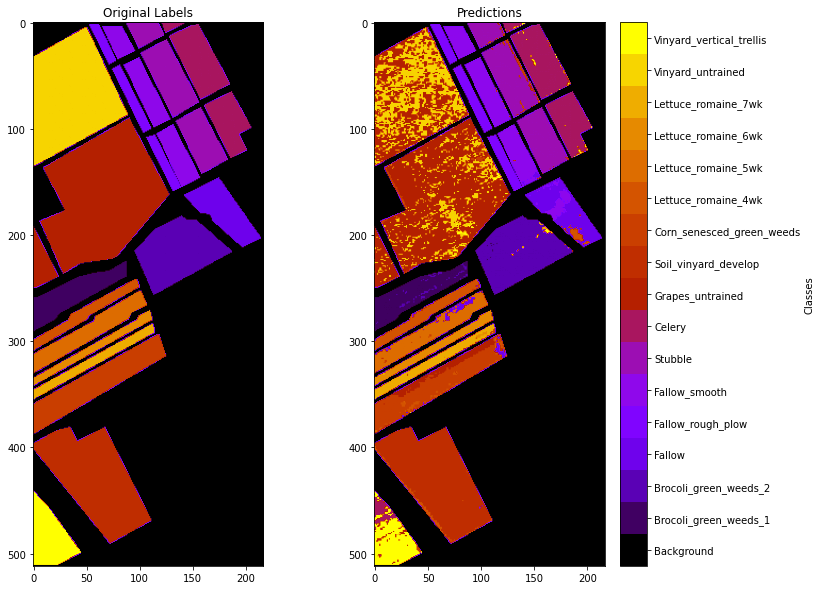

In [32]:
global GROUND_TRUTH
global NUM_CLASSES
#Establishe the name of labels
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(salinas_labels,cmap='gnuplot')

plt.subplot(1, 2, 2)
plt.title('Predictions')
plt.imshow(salinas_preds_img,cmap='gnuplot')

cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()